## Facial Keypoint detector

- Some of this code is modified from the Udacity Computer Vision Nanodegree facial keypoint detection project. 
- Some of the model training portions are modified from this [tutorial](https://debuggercafe.com/advanced-facial-keypoint-detection-with-pytorch/)

This notebook will show how to train a model to detect facial keypoints.


Facial keypoints (also called facial landmarks) are points that mark important areas of the face, such as the nose, mouth, eyes, and jawline. These key points have several applications, such as emotion recognition, pose recognition, face filters, and more. In each train and test image there is a single face with **68 keypoints mapped via (x,y) coordinates**. <br> <br> <br> 

                    
<center><img src='images/landmarks_numbered.jpg' width=30% height=30%/></center>

In [1]:
# import the required libraries
import glob
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
key_pts_df = pd.read_csv('data/training_frames_keypoints.csv')
key_pts_df.head()


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [3]:
idx = 0
image_name = key_pts_df.iloc[idx, 0]
key_pts = key_pts_df.iloc[idx, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2) # reshape to get 68 (x,y) coordinates

print(f'Image name: {image_name}')
print(f'Landmarks shape: {key_pts.shape}')

Image name: Luis_Fonsi_21.jpg
Landmarks shape: (68, 2)


#### Display some training images

In [4]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

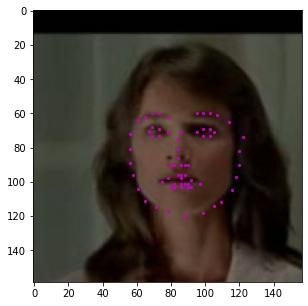

In [5]:
idx = 90
image_name = key_pts_df.iloc[idx, 0]
key_pts = key_pts_df.iloc[idx, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2) # reshape to get 68 (x,y) coordinates

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('data/training/', image_name)), key_pts)
plt.show()

## Transforms

Now, the images above are not of the same size, and neural networks often expect images that are standardized; a fixed size, with a normalized range for color ranges and coordinates, and (for PyTorch) converted from numpy lists and arrays to Tensors.

Therefore, we will need to write some pre-processing code.
Let's create four transforms:

-  ``Normalize``: to convert a color image to grayscale values with a range of [0,1], for this model we will NOT normalize the keypoints to be in a range of about [-1, 1]
-  ``Rescale``: to rescale an image to a desired size.
-  ``RandomCrop``: to crop an image randomly.
-  ``RandomRotation`` : randomly rotates image and keypoints
-  ``ToTensor``: to convert numpy images to torch images.

Something else that we will do to the data is vary the location of the face in the training images only. This will be done by making the train Rescale size large compared to the random crop size, but not too large since we need the network to actually learn what entire faces look like.

For this training we will be using color images since using all 3 color channels may provide more information that can be used by our model.

The transform classes are in data_transforms.py

Something we will do to get a more robust model is to train with mild rotations and set the rescale size close to the random crop size. Then we will tweak the network by adding more intense rotations and cropping

In [6]:
# get changes made to the external files
%load_ext autoreload
%autoreload 2

In [77]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# get custom dataset and transforms from helper file
from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, AddColorJitter, ToTensor, RandomRotate



train_transform = transforms.Compose([Rescale(255), # this needs to be larger compared random crop size
                                      RandomCrop(224),
                                      RandomRotate(15),
                                      AddColorJitter((0.75, 1.25), (0.75, 1.25), (0.75, 1.25), (0.25, 0.25)),
                                      Normalize(mode=2),
                                      ToTensor()
                                     ])

test_transform = transforms.Compose([Rescale(255),
                                     RandomCrop(224),
                                     Normalize(mode=2),
                                     ToTensor()
                                    ])

In [73]:
# create the transformed dataset
train_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                       root_dir='data/training/',
                                       transform=train_transform)

test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                      root_dir='data/test/',
                                      transform=test_transform)


print(f'Number of training images: {len(train_dataset)}')
print(f'Number of test images: {len(test_dataset)}')

Number of training images: 3462
Number of test images: 770


In [78]:
# load training data in batches
batch_size = 16

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size,
                         shuffle=True, 
                         num_workers=0)

### Inspect some transformed training images
Below we will see that some of the images and their keypoints have been rotated

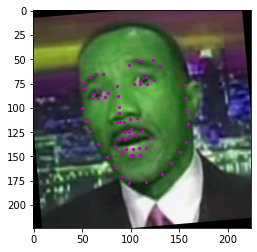

In [83]:
sample_dict = next(iter(train_loader))
sample_dict['image'].shape

idx = 1
img = sample_dict['image'][idx].squeeze().numpy().transpose((1, 2, 0))
kpt = sample_dict['keypoints'][idx]

# unnormalize image
img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]


plt.imshow(img)
plt.scatter(kpt[:, 0], kpt[:, 1], s=20, marker='.', c='m');

## Build the model
For this model we will use transfer learning and start with a resnet50 and modify the final layer.

In [84]:
import torchvision.models as models

resnet = models.resnet50(pretrained=True)

In [85]:
for name, child in resnet.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


#### Modify the final layer in order to get the correct outputs

In [86]:
resnet.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [87]:
resnet.fc = nn.Linear(2048, 136)

### Freeze and unfreeze layers for training

In [88]:
def unfreeze_layers(model, layers):
    ''' unfreezes any layer contained in layers '''

    for name, child in model.named_children():
        if name in layers:
            print(f'{name} has been unfrozen')
            for param in child.parameters():
                param.requires_grad = True

        else:
            # freeze remaining layers
            print(f'{name} has been frozen')
            for param in child.parameters():
                param.requires_grad = False

In [89]:
train_layers = ['layer4', 'avgpool', 'fc']

# if you want to train all parameters don't call this
unfreeze_layers(resnet, train_layers)

conv1 has been frozen
bn1 has been frozen
relu has been frozen
maxpool has been frozen
layer1 has been frozen
layer2 has been frozen
layer3 has been frozen
layer4 has been unfrozen
avgpool has been unfrozen
fc has been unfrozen


## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [90]:
# test the model on a batch of test images

def get_sample_output(model):
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = model(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [91]:
test_images, test_outputs, gt_pts = get_sample_output(resnet)

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 3, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


In [92]:
test_outputs[0, :10, :10] / 224

tensor([[ 1.0052e-03, -9.3672e-04],
        [ 6.3644e-04, -3.4440e-03],
        [ 1.3678e-03,  3.5702e-04],
        [-1.6463e-04, -2.1439e-04],
        [ 1.7245e-03, -1.6779e-04],
        [-8.0239e-04,  9.5780e-04],
        [-2.3279e-03,  1.1401e-03],
        [ 1.5930e-04,  9.4798e-05],
        [-1.0137e-03, -7.3241e-04],
        [ 7.6806e-04,  1.1616e-03]], grad_fn=<DivBackward0>)

In [93]:
gt_pts[0, :10, :10] + 112

tensor([[200.6170, 217.7778],
        [197.0000, 230.3951],
        [197.0000, 243.0123],
        [197.0000, 252.0247],
        [200.6170, 264.6420],
        [200.6170, 275.4568],
        [204.2340, 284.4691],
        [209.6596, 291.6790],
        [222.3191, 297.0864],
        [238.5957, 298.8889]], dtype=torch.float64)

## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [94]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


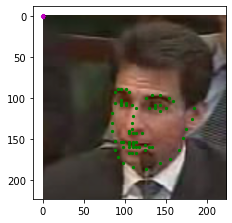

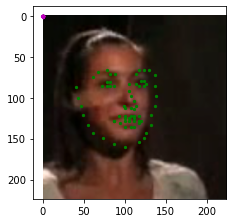

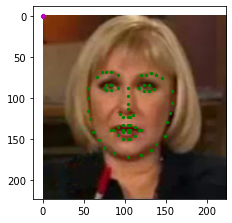

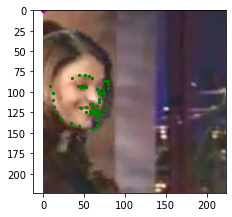

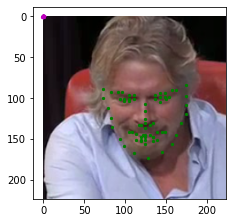

In [95]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=5):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # unnormalize image (there may be some roundoff error here, just let Python clip values for displaying)
        image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        # predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            # ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        # plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

We can see that the untrained output has a nice spread about the center of each image. Much better than a naive untraine dmodel which displays a very small cluster around the center (akin to a small dot).

## Start Training

In [97]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# place model on device
resnet = resnet.to(device)

cuda


In [98]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.SmoothL1Loss() # nn.MSELoss()

optimizer = optim.Adam(resnet.parameters(), lr=0.0005)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [99]:
# training function
def train(model, dataloader, epoch):
    print('Training')
    model.train()
    train_running_loss = 0.0
    counter = 0
    # calculate the number of batches
  
    for i, data in enumerate(dataloader):
        counter += 1
        images = data['image']
        key_pts = data['keypoints']
        images, key_pts = images.to(device), key_pts.to(device)

        # convert variables to floats for regression loss
        if device == 'cuda':
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)
        else:
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

        # flatten the keypoints
        key_pts = key_pts.view(key_pts.size(0), -1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, key_pts)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()

        # display loss
        if i % 50 == 49:    # print every 50 batches
            print('\t Epoch: {}, Batch: {}, Avg. Train Loss: {}'.format(epoch + 1, i+1, train_running_loss/counter))
        
    train_loss = train_running_loss/counter
    return train_loss

In [100]:
# validatioon function
def validate(model, dataloader, epoch):
    print('Validating')
    model.eval()
    valid_running_loss = 0.0
    counter = 0

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            counter += 1
            images = data['image']
            key_pts = data['keypoints']
            images, key_pts = images.to(device), key_pts.to(device)

            # convert variables to floats for regression loss
            if device == 'cuda':
                key_pts = key_pts.type(torch.cuda.FloatTensor)
                images = images.type(torch.cuda.FloatTensor)
            else:
                key_pts = key_pts.type(torch.FloatTensor)
                images = images.type(torch.FloatTensor)

            # flatten the keypoints
            key_pts = key_pts.view(key_pts.size(0), -1)

            outputs = model(images)
            loss = criterion(outputs, key_pts)
            valid_running_loss += loss.item()

            # display loss
            if i % 20 == 19:    # print every 20 batches
                print('\t Epoch: {}, Batch: {}, Avg. Valid Loss: {}'.format(epoch + 1, i+1, valid_running_loss/counter))
        
    valid_loss = valid_running_loss/counter
    return valid_loss

In [101]:
import time

epochs = 10

min_val_loss = np.inf

train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(resnet, train_loader, epoch)

    # pause to let cpu and gpu cool
    time.sleep(5)

    val_epoch_loss = validate(resnet, test_loader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')

    # save model every 5 epochs
    if epoch % 5 == 4:
        model_name = f'resnet_{epoch + 1}.pth'
        torch.save(resnet, os.path.join('models', model_name))

    # save model with best validation loss
    if val_epoch_loss <= min_val_loss:
        min_val_loss = val_epoch_loss
        torch.save(resnet, 'models//best_resnet.pth')

    # step the learning rate scheduler to decay learning rate
    scheduler.step()

    # pause to let cpu and gpu cool
    time.sleep(5)


Epoch 1 of 10
Training
	 Epoch: 1, Batch: 50, Avg. Train Loss: 97.38312973022461
	 Epoch: 1, Batch: 100, Avg. Train Loss: 71.48670127868652
	 Epoch: 1, Batch: 150, Avg. Train Loss: 53.25590410232544
	 Epoch: 1, Batch: 200, Avg. Train Loss: 43.353545627593995
Validating
	 Epoch: 1, Batch: 20, Avg. Valid Loss: 12.348459720611572
	 Epoch: 1, Batch: 40, Avg. Valid Loss: 12.552487421035767
Train Loss: 41.0020
Val Loss: 12.6255
Epoch 2 of 10
Training
	 Epoch: 2, Batch: 50, Avg. Train Loss: 12.218022632598878
	 Epoch: 2, Batch: 100, Avg. Train Loss: 11.190802836418152
	 Epoch: 2, Batch: 150, Avg. Train Loss: 10.620263560612996
	 Epoch: 2, Batch: 200, Avg. Train Loss: 10.161042110919952
Validating
	 Epoch: 2, Batch: 20, Avg. Valid Loss: 8.092141842842102
	 Epoch: 2, Batch: 40, Avg. Valid Loss: 7.925335335731506
Train Loss: 10.0098
Val Loss: 7.9976
Epoch 3 of 10
Training
	 Epoch: 3, Batch: 50, Avg. Train Loss: 7.858102416992187
	 Epoch: 3, Batch: 100, Avg. Train Loss: 7.932297835350036
	 Epoch:

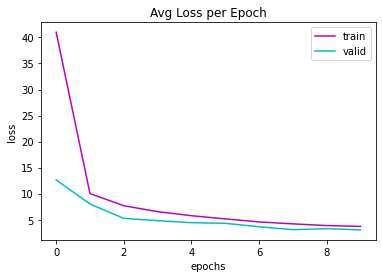

In [102]:
# plot results
plt.plot(train_loss, color='m', label='train')
plt.plot(val_loss, color='c', label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Avg Loss per Epoch')
plt.legend();

In [103]:
# place resent back on cpu and in eval mode
resnet = resnet.to('cpu')
resnet.eval()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


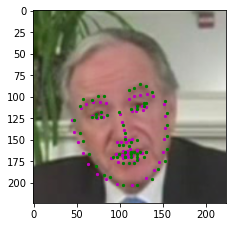

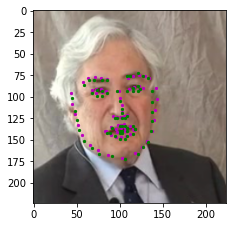

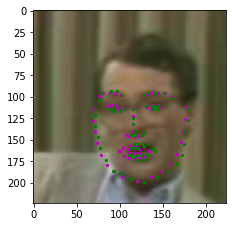

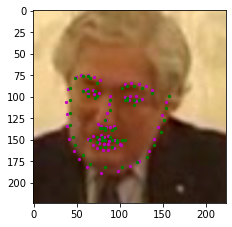

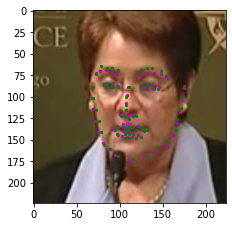

In [105]:
test_images, test_outputs, gt_pts = get_sample_output(resnet)
visualize_output(test_images, test_outputs, gt_pts)

## Train the model on highly augmented data
Now that we have a base model let's train it on some highly augmented training data to make it more robust

In [120]:
train_transform = transforms.Compose([Rescale(295), # this needs to be larger compared random crop size
                                      RandomCrop(224),
                                      RandomRotate(180),
                                      AddColorJitter((0.5, 1.5), (0.5, 1.5), (0.5, 1.5), (0.15, 0.35)),
                                      Normalize(mode=2),
                                      ToTensor()
                                     ])

test_transform = transforms.Compose([Rescale(255),
                                     RandomCrop(224),
                                     Normalize(mode=2),
                                     ToTensor()
                                    ])

In [121]:
# create the transformed dataset
train_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                       root_dir='data/training/',
                                       transform=train_transform)

test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                      root_dir='data/test/',
                                      transform=test_transform)

In [122]:
# load training data in batches
batch_size = 16

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size,
                         shuffle=True, 
                         num_workers=0)

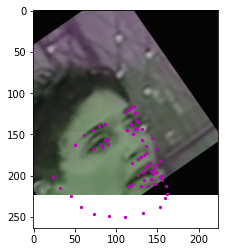

In [123]:
sample_dict = next(iter(train_loader))
sample_dict['image'].shape
# sample_dict['keypoints'].shape

idx = 1
img = sample_dict['image'][idx].squeeze().numpy().transpose((1, 2, 0))
kpt = sample_dict['keypoints'][idx]

# unnormalize image
img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]

# undo normalization of keypoints  
# kpt = kpt*50.0+100

plt.imshow(img)
plt.scatter(kpt[:, 0], kpt[:, 1], s=20, marker='.', c='m');

#### Train the model on the highly augmented data

In [125]:
resnet = resnet.to(device)

epochs = 10

min_val_loss = np.inf

train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(resnet, train_loader, epoch)

    # pause to let cpu and gpu cool
    time.sleep(5)

    val_epoch_loss = validate(resnet, test_loader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')

    # save model every 5 epochs
    if epoch % 5 == 4:
        model_name = f'resnet_{epoch + 1}.pth'
        torch.save(resnet, os.path.join('models', model_name))

    # save model with best validation loss
    if val_epoch_loss <= min_val_loss:
        min_val_loss = val_epoch_loss
        torch.save(resnet, 'models//best_resnet.pth')

    # step the learning rate scheduler to decay learning rate
    scheduler.step()

    # pause to let cpu and gpu cool
    time.sleep(5)


Epoch 1 of 10
Training
	 Epoch: 1, Batch: 50, Avg. Train Loss: 24.780544929504394
	 Epoch: 1, Batch: 100, Avg. Train Loss: 21.24987343788147
	 Epoch: 1, Batch: 150, Avg. Train Loss: 19.11129206975301
	 Epoch: 1, Batch: 200, Avg. Train Loss: 17.5927600479126
Validating
	 Epoch: 1, Batch: 20, Avg. Valid Loss: 4.8144690990448
	 Epoch: 1, Batch: 40, Avg. Valid Loss: 4.778238427639008
Train Loss: 17.2587
Val Loss: 4.9026
Epoch 2 of 10
Training
	 Epoch: 2, Batch: 50, Avg. Train Loss: 12.080107069015503
	 Epoch: 2, Batch: 100, Avg. Train Loss: 11.691106371879577
	 Epoch: 2, Batch: 150, Avg. Train Loss: 11.648250738779703
	 Epoch: 2, Batch: 200, Avg. Train Loss: 11.517913353443145
Validating
	 Epoch: 2, Batch: 20, Avg. Valid Loss: 5.383612895011902
	 Epoch: 2, Batch: 40, Avg. Valid Loss: 5.298870587348938
Train Loss: 11.5934
Val Loss: 5.2473
Epoch 3 of 10
Training
	 Epoch: 3, Batch: 50, Avg. Train Loss: 10.463701944351197
	 Epoch: 3, Batch: 100, Avg. Train Loss: 10.531309223175048
	 Epoch: 3, 

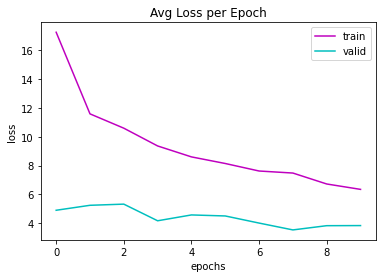

In [126]:
# plot results
plt.plot(train_loss, color='m', label='train')
plt.plot(val_loss, color='c', label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Avg Loss per Epoch')
plt.legend();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


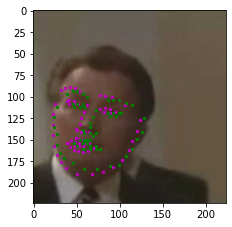

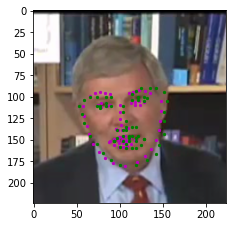

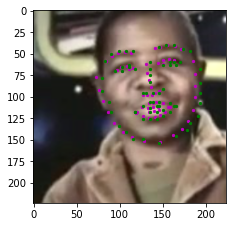

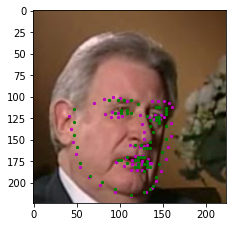

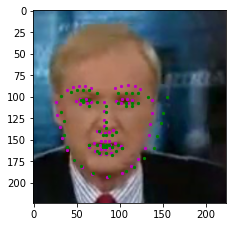

In [127]:
# place resent back on cpu and in eval mode
resnet = resnet.to('cpu')
resnet.eval()

test_images, test_outputs, gt_pts = get_sample_output(resnet)
visualize_output(test_images, test_outputs, gt_pts)

This model should be good enough for face filters. We can even see in the final image, that the model appears draw a more accurate jawline than the truth data draws

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


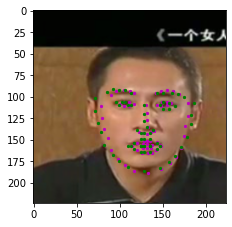

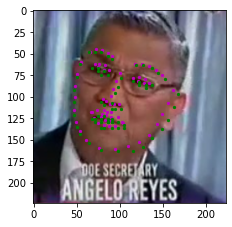

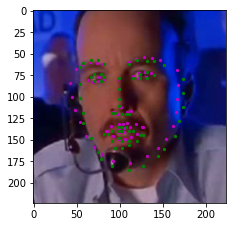

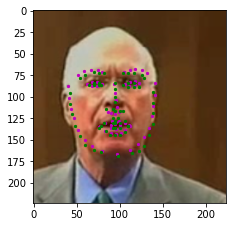

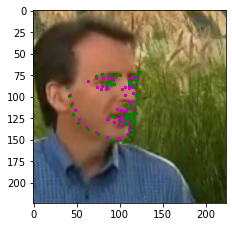

In [129]:
best_resnet = torch.load('models//best_resnet.pth')

best_resnet = best_resnet.to('cpu')
best_resnet.eval()

test_images, test_outputs, gt_pts = get_sample_output(best_resnet)
visualize_output(test_images, test_outputs, gt_pts)

Let's save the current model and keep training!

In [130]:
torch.save(resnet, 'models//best_resnet50_8.pth')

In [131]:
resnet = resnet.to(device)

epochs = 15

min_val_loss = np.inf

train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(resnet, train_loader, epoch)

    # pause to let cpu and gpu cool
    time.sleep(5)

    val_epoch_loss = validate(resnet, test_loader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')

    # save model every 5 epochs
    if epoch % 5 == 4:
        model_name = f'resnet_{epoch + 1}.pth'
        torch.save(resnet, os.path.join('models', model_name))

    # save model with best validation loss
    if val_epoch_loss <= min_val_loss:
        min_val_loss = val_epoch_loss
        torch.save(resnet, 'models//best_resnet.pth')

    # step the learning rate scheduler to decay learning rate
    scheduler.step()

    # pause to let cpu and gpu cool
    time.sleep(5)


Epoch 1 of 15
Training
	 Epoch: 1, Batch: 50, Avg. Train Loss: 6.1450198459625245
	 Epoch: 1, Batch: 100, Avg. Train Loss: 6.209797086715699
	 Epoch: 1, Batch: 150, Avg. Train Loss: 6.229290990829468
	 Epoch: 1, Batch: 200, Avg. Train Loss: 6.148269283771515
Validating
	 Epoch: 1, Batch: 20, Avg. Valid Loss: 3.427555274963379
	 Epoch: 1, Batch: 40, Avg. Valid Loss: 3.3986134469509124
Train Loss: 6.1341
Val Loss: 3.4344
Epoch 2 of 15
Training
	 Epoch: 2, Batch: 50, Avg. Train Loss: 5.72443076133728
	 Epoch: 2, Batch: 100, Avg. Train Loss: 5.858222422599792
	 Epoch: 2, Batch: 150, Avg. Train Loss: 5.8643740463256835
	 Epoch: 2, Batch: 200, Avg. Train Loss: 5.902837629318237
Validating
	 Epoch: 2, Batch: 20, Avg. Valid Loss: 5.125041568279267
	 Epoch: 2, Batch: 40, Avg. Valid Loss: 4.716179978847504
Train Loss: 5.9433
Val Loss: 4.6567
Epoch 3 of 15
Training
	 Epoch: 3, Batch: 50, Avg. Train Loss: 5.5048819398880005
	 Epoch: 3, Batch: 100, Avg. Train Loss: 5.796656618118286
	 Epoch: 3, Bat

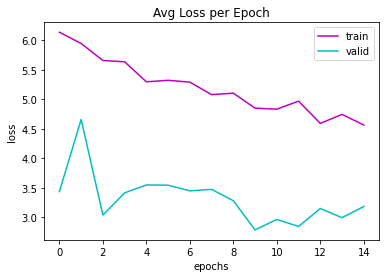

In [132]:
# plot results
plt.plot(train_loss, color='m', label='train')
plt.plot(val_loss, color='c', label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Avg Loss per Epoch')
plt.legend();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


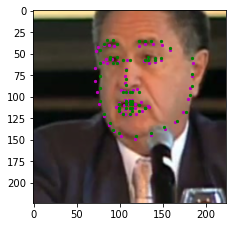

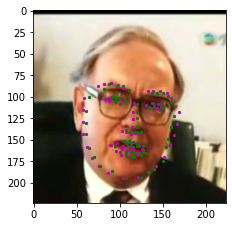

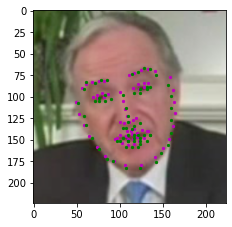

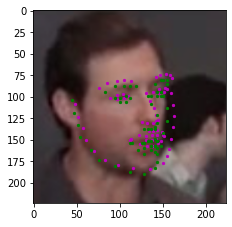

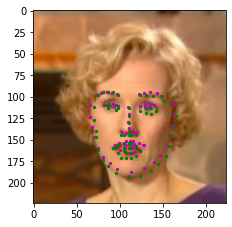

In [133]:
resnet = resnet.to('cpu')
resnet.eval()

test_images, test_outputs, gt_pts = get_sample_output(resnet)
visualize_output(test_images, test_outputs, gt_pts)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


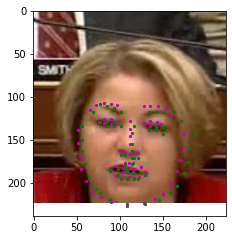

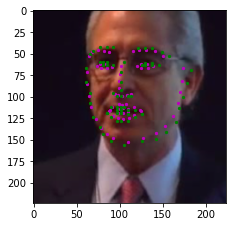

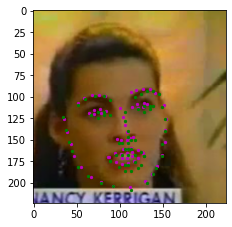

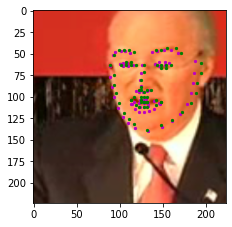

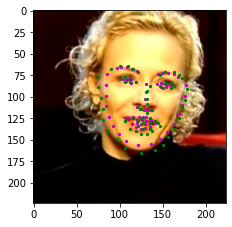

In [134]:
test_images, test_outputs, gt_pts = get_sample_output(resnet)
visualize_output(test_images, test_outputs, gt_pts)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


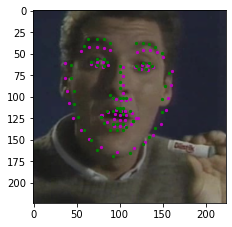

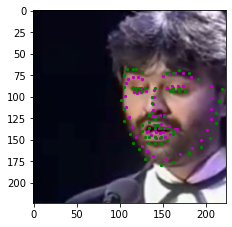

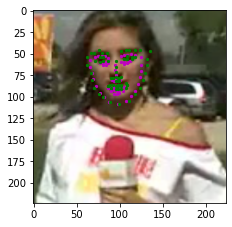

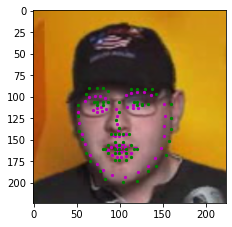

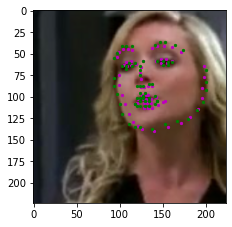

In [135]:
best_resnet = torch.load('models//best_resnet.pth')

best_resnet = best_resnet.to('cpu')
best_resnet.eval()

test_images, test_outputs, gt_pts = get_sample_output(best_resnet)
visualize_output(test_images, test_outputs, gt_pts)

In [136]:
resnet = resnet.to(device)

epochs = 25

min_val_loss = np.inf

train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(resnet, train_loader, epoch)

    # pause to let cpu and gpu cool
    time.sleep(5)

    val_epoch_loss = validate(resnet, test_loader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')

    # save model every 5 epochs
    if epoch % 5 == 4:
        model_name = f'resnet_{epoch + 1}.pth'
        torch.save(resnet, os.path.join('models', model_name))

    # save model with best validation loss
    if val_epoch_loss <= min_val_loss:
        min_val_loss = val_epoch_loss
        torch.save(resnet, 'models//best_resnet.pth')

    # step the learning rate scheduler to decay learning rate
    scheduler.step()

    # pause to let cpu and gpu cool
    time.sleep(5)

Epoch 1 of 25
Training
	 Epoch: 1, Batch: 50, Avg. Train Loss: 4.387946443557739
	 Epoch: 1, Batch: 100, Avg. Train Loss: 4.474096636772156
	 Epoch: 1, Batch: 150, Avg. Train Loss: 4.501583630243937
	 Epoch: 1, Batch: 200, Avg. Train Loss: 4.488212110996247
Validating
	 Epoch: 1, Batch: 20, Avg. Valid Loss: 2.718369781970978
	 Epoch: 1, Batch: 40, Avg. Valid Loss: 2.6586604475975038
Train Loss: 4.4861
Val Loss: 2.6432
Epoch 2 of 25
Training
	 Epoch: 2, Batch: 50, Avg. Train Loss: 4.455479474067688
	 Epoch: 2, Batch: 100, Avg. Train Loss: 4.382634742259979
	 Epoch: 2, Batch: 150, Avg. Train Loss: 4.446560041109721
	 Epoch: 2, Batch: 200, Avg. Train Loss: 4.393167444467545
Validating
	 Epoch: 2, Batch: 20, Avg. Valid Loss: 3.2758618235588073
	 Epoch: 2, Batch: 40, Avg. Valid Loss: 3.1578892052173613
Train Loss: 4.3801
Val Loss: 3.1303
Epoch 3 of 25
Training
	 Epoch: 3, Batch: 50, Avg. Train Loss: 3.7070342254638673
	 Epoch: 3, Batch: 100, Avg. Train Loss: 4.013892724514007
	 Epoch: 3, Ba

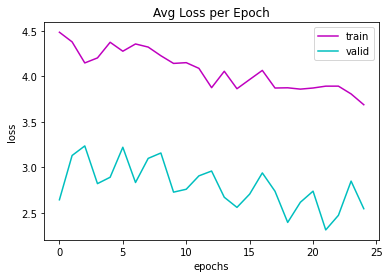

In [137]:
# plot results
plt.plot(train_loss, color='m', label='train')
plt.plot(val_loss, color='c', label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Avg Loss per Epoch')
plt.legend();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


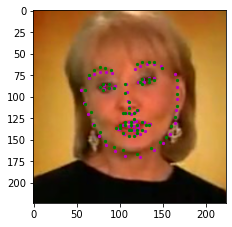

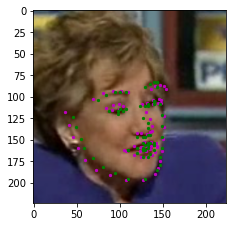

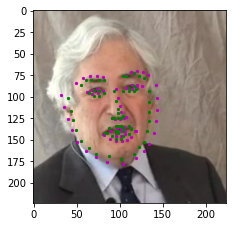

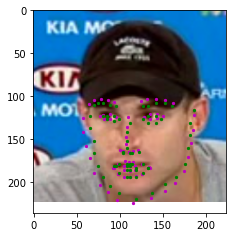

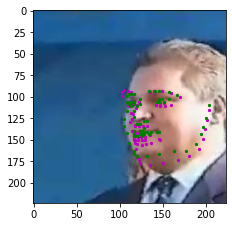

In [138]:
resnet = resnet.to('cpu')
resnet.eval()

test_images, test_outputs, gt_pts = get_sample_output(resnet)
visualize_output(test_images, test_outputs, gt_pts)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


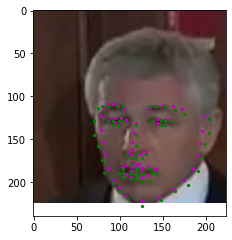

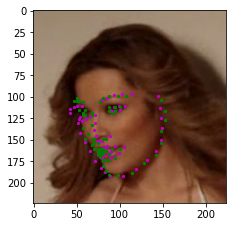

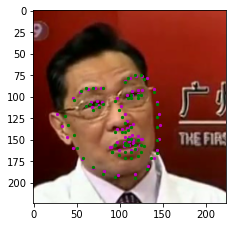

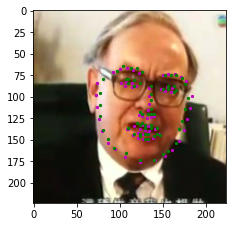

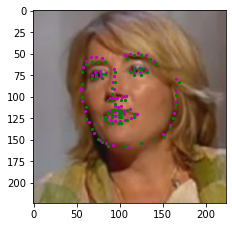

In [139]:
best_resnet = torch.load('models//best_resnet.pth')

best_resnet = best_resnet.to('cpu')
best_resnet.eval()

test_images, test_outputs, gt_pts = get_sample_output(best_resnet)
visualize_output(test_images, test_outputs, gt_pts)